## Dataset

Veamos estadísticas y otras cosas del dataset

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import django
from tqdm.auto import tqdm

os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

sys.path.append("..")
os.environ['DJANGO_SETTINGS_MODULE'] = 'news_labelling.settings'
django.setup()

from api.models import Comment, ArticleLabel, CommentLabel, Article, Batch
from django.contrib.auth.models import User

In [2]:
from django.db.models import Count, Case, When, Value

annotated_articles = Article.objects.exclude(batch__name="training").annotate(
    num_labels=Count('labels'),
    effective_labels=Count(
        Case(When(labels__is_interesting=True, then=Value(1)))
    )
)


dataset_articles = annotated_articles.filter(effective_labels=3)

skipped = 0

for art in annotated_articles:
    if art.num_labels > art.effective_labels:
        skipped +=1


print(f"Artículos totales: {Article.objects.count()}")
print(f"Artículos con 3 anotaciones: {dataset_articles.count()}")
print(f"Artículos con alguna anotación: {annotated_articles.filter(num_labels__gte=1).count()}")
print(f"Artículos que no pasaron a tercera anotación: {skipped}")

Artículos totales: 1738
Artículos con 3 anotaciones: 1238
Artículos con alguna anotación: 1725
Artículos que no pasaron a tercera anotación: 452


Carguemos directamente el JSON generado

In [3]:
import json

with open("../output/dataset.raw.json") as f:
    raw_articles = json.load(f)
print(len(raw_articles))


1238


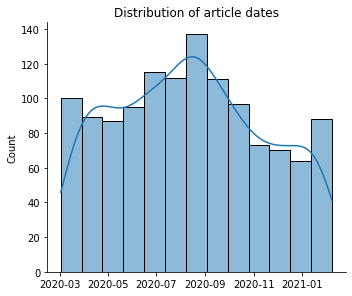

In [4]:
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

dates = [datetime.fromisoformat(d["date"].replace('Z', '+00:00')) for d in raw_articles]

ax = sns.displot(
    x=dates, 
    kde=True, 
    height=4, aspect=1.25,
)

plt.title("Distribution of article dates")
plt.savefig("figures/date_distribution.png", bbox_inches='tight')

In [5]:
from django.db.models import Sum
import pandas as pd

df_articles = pd.DataFrame(raw_articles)
df_articles.set_index("tweet_id", inplace=True)

df_articles["comments"] = df_articles["comments"].apply(lambda l: len(l))

df_count = df_articles.groupby("news")[["comments"]].sum()
df_count["articles"] = df_articles.groupby("news")["comments"].count()


df_count.loc["total"] = df_count.sum()

df_count

,comments,articles
news,,
LANACION,10378,222
clarincom,17501,370
cronica,1562,42
infobae,26834,590
perfilcom,594,14
total,56869,1238


In [6]:
print(df_count.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  comments &  articles \\
news      &           &           \\
\midrule
LANACION  &     10378 &       222 \\
clarincom &     17501 &       370 \\
cronica   &      1562 &        42 \\
infobae   &     26834 &       590 \\
perfilcom &       594 &        14 \\
total     &     56869 &      1238 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_202297/3745335889.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_count.to_latex())


In [7]:


comments = [
{
    **{"article_id": art["tweet_id"]},
    **comment
} for art in raw_articles for comment in art["comments"]]


/home/jmperez/projects/news-labelling/.venv/lib/python3.8/site-packages/seaborn/_core.py:1057: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  comp_col.loc[orig.index] = pd.to_numeric(axis.convert_units(orig))


ValueError: cannot reindex on an axis with duplicate labels

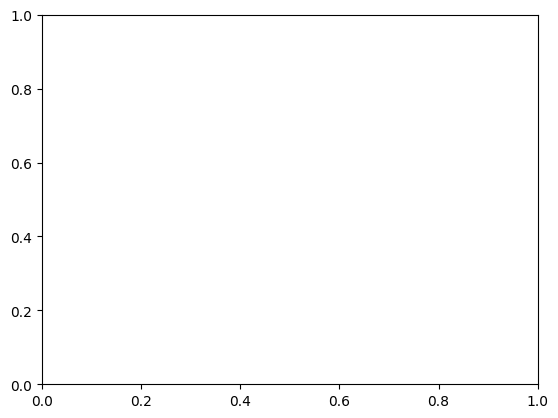

In [8]:
df_comments = pd.DataFrame(comments)
df_comments["one_hateful"] = df_comments["HATEFUL"].apply(lambda x: len(x) > 0)

user_counts = df_comments["user_id"].value_counts().to_frame("comments")
hateful_counts = df_comments[df_comments["one_hateful"]]["user_id"].value_counts().to_frame("hateful_comments")

data = pd.concat([user_counts, hateful_counts]).fillna(0).astype(int)
sns.histplot(data=data, x="comments", hue=None, bins=12)
sns.histplot(data=data, x="hateful_comments", hue=None, bins=12, color="red")

plt.ylabel("Number of users")
plt.xlabel("Number of comments")
plt.title("Histogram of number of comments per user")
plt.semilogy()

In [ ]:
hateful = data[data["hateful_comments"] > 0]

hateful.mean(), hateful.std()

(comments            0.000000
 hateful_comments    1.441234
 dtype: float64,
 comments            0.000000
 hateful_comments    1.238882
 dtype: float64)

In [ ]:
(hateful["hateful_comments"] > 10).sum()

28

In [11]:
df_comments["user_id"].value_counts()

2786327356             60
4330728869             58
1217504583947296769    56
990352152563417088     44
1556207534             41
                       ..
148449154               1
368576045               1
596889453               1
97235437                1
1132308890              1
Name: user_id, Length: 29781, dtype: int64

Text(0.5, 1.0, 'Histogram of hateful annotations per comment')

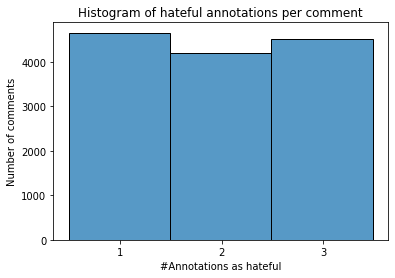

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

votes = [len(c['HATEFUL']) for c in comments if c['HATEFUL']]

sns.histplot(x=votes, bins=[0.99, 1.99, 2.99, 3.99])

plt.xticks([1.5, 2.5, 3.5], [1, 2, 3])
plt.xlabel("#Annotations as hateful")
plt.ylabel("Number of comments")
plt.title("Histogram of hateful annotations per comment")

In [14]:
possibly_hateful = len([c for c in comments if len(c['HATEFUL']) > 0])
hateful = len([c for c in comments if len(c['HATEFUL']) >= 2])

full_agreement = len([c for c in comments if len(c['HATEFUL']) == 3])

print(f"Comentarios totales                             : {len(comments)}")
print(f"Comentarios con >= 1 etiqueta de discriminación : {possibly_hateful}")
print(f"Comentarios con >= 2 etiqueta de discriminación : {hateful}")
print(f"Comentarios con >= 3 etiqueta de discriminación : {full_agreement}")
print(f"Ratio de comentarios odiosos (>= 2) sobre totales = {hateful / len(comments):.3f}")

Comentarios totales                             : 56869
Comentarios con >= 1 etiqueta de discriminación : 13366
Comentarios con >= 2 etiqueta de discriminación : 8715
Comentarios con >= 3 etiqueta de discriminación : 4514
Ratio de comentarios odiosos (>= 2) sobre totales = 0.153


## Agreement

Uso el código que ya hice con los objetos de Django que es más cómodo...

In [15]:
from api.metrics import AgreementCalculator

calculator = AgreementCalculator(articles=dataset_articles)

In [16]:
calculator.users = None

In [17]:
categories = [
    'HATE',
    'CALLS',
    'MUJER',
    'LGBTI',
    'RACISMO',
    'POBREZA',
    'DISCAPACIDAD',
    'POLITICA',
    'ASPECTO',
    'CRIMINAL',
]

agreement_df = pd.DataFrame([{
    "Category": category,
    "Agreement": calculator.get_agreement(on=category)[0],
} for category in categories])
agreement_df.set_index("Category")

,Agreement
Category,
HATE,0.579610
CALLS,0.641360
MUJER,0.783391
LGBTI,0.920701
RACISMO,0.929094
POBREZA,0.706778
DISCAPACIDAD,0.849856
POLITICA,0.808519
ASPECTO,0.871752


Lo calculamos de nuevo por si acaso

In [21]:
keys = [
 'HATEFUL',
 'CALLS',
 'WOMEN',
 'LGBTI',
 'RACISM',
 'CLASS',
 'POLITICS',
 'DISABLED',
 'APPEARANCE',
 'CRIMINAL',
]

annotators = set(annotator for article in raw_articles for comment in article["comments"] for annotator in comment["annotators"])

idx = pd.MultiIndex.from_product(
    [keys, annotators],
    names=["categoria", "etiquetador"]
)
comment_ids = [comment["id"] for article in raw_articles for comment in article["comments"]]

annotation_df = pd.DataFrame(index=idx, columns=comment_ids)
strict_df = pd.DataFrame(index=idx, columns=comment_ids)

for article in tqdm(raw_articles):
    for comment in article["comments"]:
        for annotator in comment["annotators"]:
            is_hateful = annotator in comment["HATEFUL"]
            annotation_df.loc[("HATEFUL", annotator), comment["id"]] = is_hateful
            strict_df.loc[("HATEFUL", annotator), comment["id"]] = is_hateful

            if is_hateful:
                for key in keys[1:]:
                    annotation_df.loc[(key, annotator), comment["id"]] = annotator in comment[key]
                    strict_df.loc[(key, annotator), comment["id"]] = annotator in comment[key]
            else:
                # En modo libre meto false
                for key in keys[1:]:
                    strict_df.loc[(key, annotator), comment["id"]] = False

100%|██████████| 1238/1238 [04:31<00:00,  4.56it/s]


In [22]:
import krippendorff

alphas = {key:krippendorff.alpha(annotation_df.loc[key].values.astype(float)) for key in keys}

print(pd.DataFrame([alphas]).T.sort_values(0).to_latex())
    


\begin{tabular}{lr}
\toprule
{} &         0 \\
\midrule
HATEFUL    &  0.579610 \\
CALLS      &  0.641360 \\
CLASS      &  0.706778 \\
WOMEN      &  0.783391 \\
POLITICS   &  0.808519 \\
DISABLED   &  0.849856 \\
APPEARANCE &  0.871752 \\
LGBTI      &  0.920701 \\
RACISM     &  0.929094 \\
CRIMINAL   &  0.931163 \\
\bottomrule
\end{tabular}



Obs: acá los agreements por categorías se ven sólo en aquellos comentarios que son marcados como odiosos, y sólo entre aquellos anotadores que hayan marcado como odioso

En términos de cómo calculamos el alpha de Krippendorff: supongamos que estamos calculando el agreement de MUJER. Si anotador A1 y A2 marcaron como odioso C1, y ambos marcaron mujer => en ambos va 1. Anotador A3 no marcó como odioso ese comentario => va nan. En C2, A1 no marcó como odioso y A2 y A3 marcaron como odioso contra MUJER. En C3, A3 no marcó odioso, y A1 sí pero sin marcar MUJER y A2 marcó odioso y MUJER.

La matriz quedaría así:

|   |C1   |C2    | C3   |
|---|-----|------|------|
|A1 | 1   | nan  | 0    |
|A2 | 1   | 1    | 1    |
|A3 | nan | 1    | nan  |

## Modo libre


In [24]:
import krippendorff

alphas = {key:krippendorff.alpha(strict_df.loc[key].values.astype(float)) for key in keys}

pd.DataFrame([alphas]).T
    


,0
HATEFUL,0.579610
CALLS,0.478974
WOMEN,0.530894
LGBTI,0.554911
RACISM,0.607848
CLASS,0.403643
POLITICS,0.508691
DISABLED,0.596529
APPEARANCE,0.734578
CRIMINAL,0.617393


## Máxima performance esperada

Calculemos el F1 promedio entre anotadores, usando las anotaciones de uno y otro como estándar

In [39]:
from sklearn.metrics import f1_score
import numpy as np
import json

test_ids = json.load(open("test_ids.json"))

annotators = annotation_df.loc["HATEFUL"].index


max_performance = {}

ia_results = []

for key in keys:
    scores = []

    for i in range(len(annotators)):
        for j in range(i+1, len(annotators)):
            a1 = annotators[i]
            a2 = annotators[j]

            tweets_both_annotated = annotation_df.loc[(key, a1)].notna() & annotation_df.loc[(key, a2)].notna()

            tweets_both_annotated = (tweets_both_annotated & tweets_both_annotated.index.isin(test_ids))
            a1_annotations = annotation_df.loc[(key, a1), tweets_both_annotated]
            a2_annotations = annotation_df.loc[(key, a2), tweets_both_annotated]

            assert a1_annotations.isna().sum() == 0
            assert a2_annotations.isna().sum() == 0


            score = f1_score(a1_annotations.values.astype(int), a2_annotations.values.astype(int), average="binary")
            
            scores.append(score)
            #print(f"F1 between {a1} - {a2} = {score:.3f}")
            
    ia_results.append({
        "key": key,
        "F1 mean": np.array(scores).mean(),
        "F1 median": sorted(scores)[len(scores)//2],
    })
pd.DataFrame(ia_results).set_index("key")

/home/jmperez/.local/share/virtualenvs/news-labelling-8oK1LTa4/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1495: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/home/jmperez/.local/share/virtualenvs/news-labelling-8oK1LTa4/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1495: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/home/jmperez/.local/share/virtualenvs/news-labelling-8oK1LTa4/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1495: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/home/jmperez/.local/share/virtualenvs/news-labelling-8oK1LTa4/lib/python3.8/si

,F1 mean,F1 median
key,,
HATEFUL,0.652590,0.675111
CALLS,0.604281,0.703704
WOMEN,0.725812,0.736842
LGBTI,0.893906,0.960000
RACISM,0.945894,0.959276
CLASS,0.731000,0.750000
POLITICS,0.737078,0.777778
DISABLED,0.797335,0.880000
APPEARANCE,0.803394,0.902439


In [41]:
print(pd.DataFrame(ia_results).set_index("key").to_latex(fm))

\begin{tabular}{lrr}
\toprule
{} &   F1 mean &  F1 median \\
key        &           &            \\
\midrule
HATEFUL    &  0.652590 &   0.675111 \\
CALLS      &  0.604281 &   0.703704 \\
WOMEN      &  0.725812 &   0.736842 \\
LGBTI      &  0.893906 &   0.960000 \\
RACISM     &  0.945894 &   0.959276 \\
CLASS      &  0.731000 &   0.750000 \\
POLITICS   &  0.737078 &   0.777778 \\
DISABLED   &  0.797335 &   0.880000 \\
APPEARANCE &  0.803394 &   0.902439 \\
CRIMINAL   &  0.818097 &   0.947368 \\
\bottomrule
\end{tabular}



## Modo libre entre anotadores


In [46]:
from sklearn.metrics import f1_score
import numpy as np
import json

test_ids = json.load(open("test_ids.json"))

annotators = strict_df.loc["HATEFUL"].index


max_performance = {}

strict_ia_results = []

for key in keys:
    scores = []

    for i in range(len(annotators)):
        for j in range(i+1, len(annotators)):
            a1 = annotators[i]
            a2 = annotators[j]

            tweets_both_annotated = strict_df.loc[(key, a1)].notna() & strict_df.loc[(key, a2)].notna()

            tweets_both_annotated = (tweets_both_annotated & tweets_both_annotated.index.isin(test_ids))
            a1_annotations = strict_df.loc[(key, a1), tweets_both_annotated]
            a2_annotations = strict_df.loc[(key, a2), tweets_both_annotated]

            assert a1_annotations.isna().sum() == 0
            assert a2_annotations.isna().sum() == 0


            score = f1_score(a1_annotations.values.astype(int), a2_annotations.values.astype(int), average="binary")
            
            scores.append(score)
            #print(f"F1 between {a1} - {a2} = {score:.3f}")
            
    strict_ia_results.append({
        "key": key,
        "F1 mean": np.array(scores).mean(),
        "F1 median": sorted(scores)[len(scores)//2],
    })
pd.DataFrame(strict_ia_results).set_index("key")

/home/jmperez/.local/share/virtualenvs/news-labelling-8oK1LTa4/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1495: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


,F1 mean,F1 median
key,,
HATEFUL,0.652590,0.675111
CALLS,0.434161,0.495050
WOMEN,0.489695,0.467662
LGBTI,0.595980,0.576577
RACISM,0.653274,0.644444
CLASS,0.443186,0.444444
POLITICS,0.460940,0.436090
DISABLED,0.550251,0.600000
APPEARANCE,0.648590,0.742857


In [49]:

print(pd.DataFrame(strict_ia_results).set_index("key").to_latex())

\begin{tabular}{lrr}
\toprule
{} &   F1 mean &  F1 median \\
key        &           &            \\
\midrule
HATEFUL    &  0.652590 &   0.675111 \\
CALLS      &  0.434161 &   0.495050 \\
WOMEN      &  0.489695 &   0.467662 \\
LGBTI      &  0.595980 &   0.576577 \\
RACISM     &  0.653274 &   0.644444 \\
CLASS      &  0.443186 &   0.444444 \\
POLITICS   &  0.460940 &   0.436090 \\
DISABLED   &  0.550251 &   0.600000 \\
APPEARANCE &  0.648590 &   0.742857 \\
CRIMINAL   &  0.526596 &   0.580153 \\
\bottomrule
\end{tabular}



## Gold label
Calculemos contra el gold-label. Primero, en modo jerárquico

In [37]:

gold_label = pd.DataFrame(columns=annotation_df.columns, index=keys)

gold_label.loc["HATEFUL"] = annotation_df.loc["HATEFUL"].fillna(False).sum() >= 2
gold_label.loc["CALLS"] = annotation_df.loc["CALLS"].fillna(False).sum() >= 2

hateful = gold_label.columns[gold_label.loc["HATEFUL"]]

for key in keys[2:]:
    gold_label.loc[key, hateful] = annotation_df.loc[key, hateful].fillna(0).sum() > 0

results = []
for key in keys:
    
    scores = []

    for i in range(len(annotators)):
        a1 = annotators[i]

        tweets_both_annotated = annotation_df.loc[(key, a1)].notna()
        tweets_both_annotated = (tweets_both_annotated & tweets_both_annotated.index.isin(test_ids))

        if key not in {"HATEFUL", "CALLS"}:
            tweets_both_annotated = tweets_both_annotated & tweets_both_annotated.index.isin(hateful)

        a1_annotations = annotation_df.loc[(key, a1), tweets_both_annotated]
        a2_annotations = gold_label.loc[key, tweets_both_annotated]

        assert a1_annotations.isna().sum() == 0
        assert a2_annotations.isna().sum() == 0

        score = f1_score(a1_annotations.values.astype(int), a2_annotations.values.astype(int), average="binary")
            
        scores.append(score)
        #print(f"F1 between {a1} - {a2} = {score:.3f}")
            
    results.append({
        "key": key,
        "F1 Mean": np.array(scores).mean(),
        "F1 Median": sorted(scores)[len(scores)//2],
    })

pd.DataFrame(results).set_index("key")

,F1 Mean,F1 Median
key,,
HATEFUL,0.828552,0.851546
CALLS,0.774132,0.914826
WOMEN,0.837138,0.827586
LGBTI,0.966057,0.974359
RACISM,0.966779,0.973196
CLASS,0.805842,0.839161
POLITICS,0.892089,0.918919
DISABLED,0.897638,0.939227
APPEARANCE,0.902657,0.949309


In [45]:

print(pd.DataFrame(results).set_index("key").to_latex())

\begin{tabular}{lrr}
\toprule
{} &   F1 Mean &  F1 Median \\
key        &           &            \\
\midrule
HATEFUL    &  0.828552 &   0.851546 \\
CALLS      &  0.774132 &   0.914826 \\
WOMEN      &  0.837138 &   0.827586 \\
LGBTI      &  0.966057 &   0.974359 \\
RACISM     &  0.966779 &   0.973196 \\
CLASS      &  0.805842 &   0.839161 \\
POLITICS   &  0.892089 &   0.918919 \\
DISABLED   &  0.897638 &   0.939227 \\
APPEARANCE &  0.902657 &   0.949309 \\
CRIMINAL   &  0.961483 &   0.978887 \\
\bottomrule
\end{tabular}



## Modo libre gold standard

In [38]:
#three_times = my_df.loc["HATEFUL"].notna().sum() == 3

gold_label = pd.DataFrame(columns=strict_df.columns, index=keys)

gold_label.fillna(False, inplace=True)

gold_label.loc["HATEFUL"] = strict_df.loc["HATEFUL"].fillna(False).sum() >= 2
gold_label.loc["CALLS"] = strict_df.loc["CALLS"].fillna(False).sum() >= 2
hateful = gold_label.columns[gold_label.loc["HATEFUL"]]

for key in keys[2:]:
    gold_label.loc[key, hateful] = strict_df.loc[key, hateful].fillna(0).sum() > 0

strict_results = []

for key in keys:

    scores = []

    for i in range(len(annotators)):
        a1 = annotators[i]

        tweets_both_annotated = strict_df.loc[(key, a1)].notna()
        tweets_both_annotated = (tweets_both_annotated & tweets_both_annotated.index.isin(test_ids))

        if key not in {"HATEFUL", "CALLS"}:
            tweets_both_annotated = tweets_both_annotated & tweets_both_annotated.index.isin(hateful)

        a1_annotations = strict_df.loc[(key, a1), tweets_both_annotated]
        a2_annotations = gold_label.loc[key, tweets_both_annotated]

        assert a1_annotations.isna().sum() == 0
        assert a2_annotations.isna().sum() == 0

        score = f1_score(a1_annotations.values.astype(int), a2_annotations.values.astype(int), average="binary")
            
        scores.append(score)
        #print(f"F1 between {a1} - {a2} = {score:.3f}")
            
    strict_results.append({
        "key": key,
        "F1 Mean": np.array(scores).mean(),
        "F1 Median": sorted(scores)[len(scores)//2],
    })


pd.DataFrame(strict_results).set_index("key")


,F1 Mean,F1 Median
key,,
HATEFUL,0.828552,0.851546
CALLS,0.704251,0.842444
WOMEN,0.740602,0.759398
LGBTI,0.846210,0.915254
RACISM,0.871221,0.878957
CLASS,0.722012,0.731707
POLITICS,0.795182,0.815534
DISABLED,0.812773,0.842105
APPEARANCE,0.831490,0.914634


In [50]:

print(pd.DataFrame(strict_results).set_index("key").to_latex())

\begin{tabular}{lrr}
\toprule
{} &   F1 Mean &  F1 Median \\
key        &           &            \\
\midrule
HATEFUL    &  0.828552 &   0.851546 \\
CALLS      &  0.704251 &   0.842444 \\
WOMEN      &  0.740602 &   0.759398 \\
LGBTI      &  0.846210 &   0.915254 \\
RACISM     &  0.871221 &   0.878957 \\
CLASS      &  0.722012 &   0.731707 \\
POLITICS   &  0.795182 &   0.815534 \\
DISABLED   &  0.812773 &   0.842105 \\
APPEARANCE &  0.831490 &   0.914634 \\
CRIMINAL   &  0.841534 &   0.929245 \\
\bottomrule
\end{tabular}



## Algunos ejemplos

Leamos ahora el ya asignado

In [ ]:
with open("../output/dataset.json") as f:
    articles = json.load(f)
    
comments = [{**comm, **{"article": art}} for art in articles for comm in art["comments"]]

In [ ]:
import random

char_tweets = {char:[] for char in keys[1:] if char != "CALLS"}

for comment in comments:
    for key in char_tweets:
        if comment[key]:
            char_tweets[key].append(comment)

# Esto es medio trucho pero bueno

#for arr in char_tweets.values():
#    random.shuffle(arr)

df_count = pd.DataFrame([
    {
        "Characteristic": k,
        "Count":len(v),
        "Calls to Action": len([c for c in v if c["CALLS"]])
    } for k, v in char_tweets.items()])

df_count.set_index("Characteristic", inplace=True)
df_count.sort_values("Count", inplace=True, ascending=False)

df_count

In [ ]:
print(df_count.to_latex())

In [ ]:
import random

random.seed(2021)

data = []

selected_ids = {
    "WOMEN": {
        407976, 371887, 407372, 350369, 404390, 354563, 360696, 408112, 387787, 406491, 
        333431, 333380, 366020
    },
    "LGBTI": {348304, 401013, 396655, 369370, 365953, 397528, 377415, 394007, 400769},
    "RACISM": {345526, 346189, 361417, 348501, 407751, 403677, 376555, 342786, 338586},
    "CRIMINAL": {385282, 343734, 359714, 367753, 374584},
    "CLASS": {344236, 335045, 355946, 379401, 345243, 353042, 331749, 367136},
    
    "POLITICS": {364045, 382819, 368191, 405420, 365289},
    "APPEARANCE": {377430, 389419, 401537, 352592, 368514},
    "DISABLED": {373983, 329510, 369358, 397780},
    
    "CALLS": {345395, 361092, 370678, 339375, 403667, 379905, 370694, },
}

for char, tweets in char_tweets.items():
    print(f"\n\n## {char}", "\n" * 3)
    random.shuffle(tweets)
    for tweet in tweets[:25]:
        article = tweet["article"]
        print(f"- ({tweet['id']}) {tweet['text']} |||| {article['title']}")
        data.append({
            "article_id": article['tweet_id'],
            "comment_id": comment["id"],
            "characteristic": char,
            "text": tweet['text'], 
            "context": article['title'],
        })

In [ ]:
pd.options.display.max_colwidth = 240
pd.options.display.max_rows = 120

id2comment = {comment["id"]:comment for comment in comments}

data = []

for characteristic, comment_ids in selected_ids.items():
    for comment_id in comment_ids:
        comment = id2comment[comment_id]
        article = comment["article"]
        data.append({
            "comment_id": comment_id,
            "characteristic": characteristic,
            "context": article["title"],
            "text": comment["text"],
            
        })
df_selected = pd.DataFrame(data)

df_selected

In [ ]:
df

In [ ]:
import re
pd.options.display.max_colwidth = 256

#sub_data = [d for d in data if d["characteristic"] in {"WOMEN", "LGBTI"}]

sub_data = df_selected

df_char = pd.DataFrame(sub_data)[["characteristic", "context", "text"]]
table = df_char.to_latex(index=False, col_space=1)

table = re.sub(r"&\s+", "& ", table)

print(table)

In [ ]:
data[0]